In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './mixed_model_save_t2/'


In [ ]:
import numpy as np
import transformers
from transformers import BertConfig, BertModel, BertTokenizer,  BertForSequenceClassification

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:

import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30548, 256, padding_idx=0)
      (position_embeddings): Embedding(256, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-7): 8 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, e

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import pandas as pd
# Load the dataset into a pandas dataframe.
tst = pd.read_csv("hg006_bcf.csv", low_memory=False)

# Report the number of sentences.
print('Number of training lines: {:,}\n'.format(tst.shape[0]))

# Display 10 random rows from the data.

tst = tst[1:]

Number of training lines: 4,520,834



In [ ]:
tst.sample(3)

,QUAL,FILTER,INFO,FORMAT,HG003
1370139,225.417,1,DP=11;VDB=0.929985;FS=0.0;SGB=-0.670168;MQ0F=0...,GT:PL,"1/1:255,30,0"
4431973,46.4146,1,DP=2;VDB=0.6;FS=0.0;SGB=-0.453602;MQ0F=0.0;AC=...,GT:PL,"1/1:76,6,0"
1257720,45.8734,0,DP=10;VDB=0.0588947;RPBZ=-2.33353;BQBZ=-1.4142...,GT:PL,"0/1:79,0,165"


In [ ]:
import pandas as pd

# Report the number of sentences.
print(tst.groupby('FILTER').size())

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(tst.shape[0]))



# Get all column names except the one to exclude
columns_to_merge = [col for col in tst.columns if col != 'FILTER']

# Define a lambda function to merge the values of selected columns
merge_columns = lambda row: ' '.join(str(row[col]) for col in columns_to_merge)

# Merge columns using the defined function
tst['merged_column'] = tst.apply(merge_columns, axis=1)

# Drop the original columns
tst = tst.drop(columns=columns_to_merge)

# Print the resulting DataFrame
print(tst.sample(3))

# Create sentence and label lists
sentences = tst.merged_column.values
labels = tst.FILTER.values
labels = labels.astype(np.int64)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    input_ids.append(encoded_sent)



FILTER
0    3694660
1     826173
dtype: int64
Number of test sentences: 4,520,833

        FILTER                                      merged_column
3419687      0  225.417 DP=14;VDB=0.754357;FS=0.0;SGB=-0.68635...
1925583      0  60.3945 INDEL;IDV=6;IMF=0.428571;DP=14;VDB=0.0...
4079958      0  28.8816 DP=8;VDB=0.549396;RPBZ=-0.447214;BQBZ=...


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  150


In [ ]:
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
MAX_LEN = max([len(sen) for sen in input_ids])+2
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 10000

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import time
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
t0 = time.time()

# Put model in evaluation mode
model.eval()

# Initialize variables for the confusion matrix
all_preds = []
all_labels = []
all_probabilities = []
# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Append predictions and labels to calculate the confusion matrix
  all_preds.extend(np.argmax(logits, axis=1))
  all_labels.extend(label_ids)

  # Append probability scores for ROC curve
  probabilities = torch.softmax(torch.from_numpy(logits), dim=1)
  all_probabilities.extend(probabilities[:, 1].cpu().numpy())
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')
print("  Testing took: {:}".format(format_time(time.time() - t0)))



Predicting labels for 4,520,833 test sentences...
    DONE.
  Testing took: 0:16:03


Confusion Matrix:
[[3551084  143576]
 [ 442903  383270]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92   3694660
           1       0.73      0.46      0.57    826173

    accuracy                           0.87   4520833
   macro avg       0.81      0.71      0.75   4520833
weighted avg       0.86      0.87      0.86   4520833

Accuracy score:
0.8702719167020768
Weighted precision_recall_f1score:
(0.8595704709564072, 0.8702719167020768, 0.8584473359648994, None)
ROC AUC Score: 0.86413


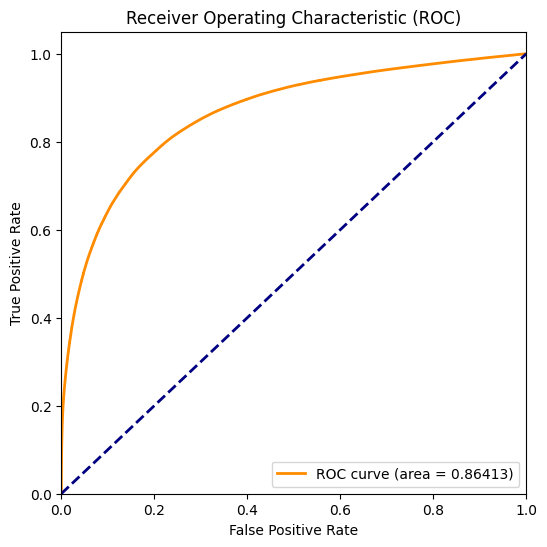

In [ ]:
# Flatten the predictions and true labels
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(confusion_mat)

print(classification_report(all_labels, all_preds))
print("Accuracy score:")
print(accuracy_score(all_labels, all_preds))
print("Weighted precision_recall_f1score:")
print(precision_recall_fscore_support(all_labels, all_preds, average = 'weighted'))

# Calculate ROC AUC score
roc_auc = roc_auc_score(all_labels, all_probabilities, average='weighted')

print(f"ROC AUC Score: {roc_auc:.5f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(flat_true_labels, all_probabilities)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.5f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.5f' % mcc)

MCC: 0.51194
